In [77]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ezc3d import c3d
from scipy.signal import resample
from scipy.io import loadmat, savemat
from joblib import load, dump
from tqdm import tqdm
from scipy.signal import butter, lfilter

In [3]:
PATH_DATASETS = '../../Dataset/'
PATH_DATASET_2 = 'gait-dbase-2/'

N_SAMPLES = 2048
FORCE_THRESHOLD = 20
TOE_HEIGTH_THRESHOLD = 40

In [78]:
class GrfFilter(object): 
    @staticmethod
    def butter_lowpass(cutoff, fs, order):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def apply(data, cutoff=10, fs=2000, order=2):
        b, a = GrfFilter.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        y = y - np.median(y)
        return y

In [94]:
path = os.path.join(PATH_DATASETS, PATH_DATASET_2)
subjects = os.listdir(path)

features = pd.DataFrame()
target = pd.DataFrame()

records = []
n_samples = 0
n_bad_samples = 0

for subject in tqdm(subjects):
    velocities_path = os.path.join(path, subject, 'Raw_Data')
    velocities = os.listdir(velocities_path)

    for velocity in velocities:

        files_path = os.path.join(velocities_path, velocity)
        files = os.listdir(files_path)

        for filename in files:
            content = c3d(os.path.join(files_path, filename), extract_forceplat_data=True)
            
            trajectory_x_r = content['data']['points'][0, 6:11, :]
            trajectory_y_r = content['data']['points'][1, 6:11, :]
            trajectory_z_r = content['data']['points'][2, 6:11, :]

            trajectory_x_l = content['data']['points'][0, 18:23, :]
            trajectory_y_l = content['data']['points'][1, 18:23, :]
            trajectory_z_l = content['data']['points'][2, 18:23, :]

            trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=1).T
            trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=1).T
            trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=1).T

            trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=1).T
            trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=1).T
            trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=1).T

            # force_z_1 = content['data']['platform'][0]['force'][2, :]
            force_z_2 = content['data']['platform'][1]['force'][2, :]
            force_z_3 = content['data']['platform'][2]['force'][2, :]
            force_z_4 = content['data']['platform'][3]['force'][2, :]
            force_z_5 = content['data']['platform'][4]['force'][2, :]
            # force_z_6 = content['data']['platform'][5]['force'][2, :]

            # force_z_1 = GrfFilter.apply(force_z_1)
            force_z_2 = GrfFilter.apply(force_z_2)
            force_z_3 = GrfFilter.apply(force_z_3)
            force_z_4 = GrfFilter.apply(force_z_4)
            force_z_5 = GrfFilter.apply(force_z_5)
            # force_z_6 = GrfFilter.apply(force_z_6)

            grf_combined_r = force_z_2 + force_z_4
            grf_combined_l = force_z_3 + force_z_5

            grf_mask_r = (grf_combined_r >= FORCE_THRESHOLD)
            grf_mask_l = (grf_combined_l >= FORCE_THRESHOLD)

            grf_start_r = np.min(np.argwhere(grf_mask_r == True))
            grf_end_r = np.max(np.argwhere(grf_mask_r == True))

            swing_period_r = np.sum(grf_combined_r[grf_start_r:grf_end_r] <= FORCE_THRESHOLD)

            force_z_r = grf_combined_r[(grf_start_r - swing_period_r):(grf_end_r + swing_period_r)]

            break
        break
    break

  0%|          | 0/16 [00:01<?, ?it/s]


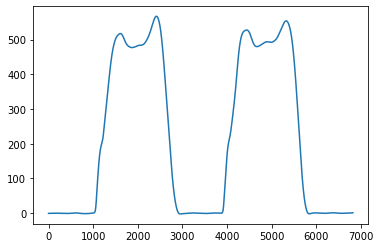

In [95]:
plt.plot(force_z_r)

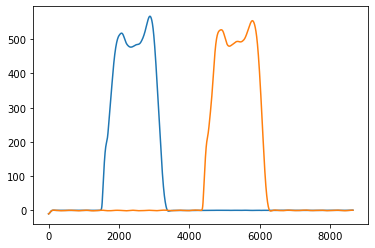

In [92]:
plt.plot(force_z_2)
plt.plot(force_z_4)

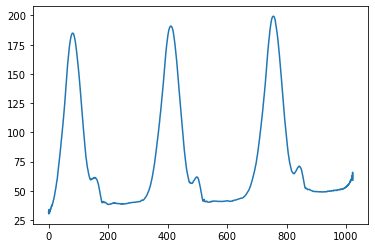

In [90]:
plt.plot(trajectory_z_r[:, 4])

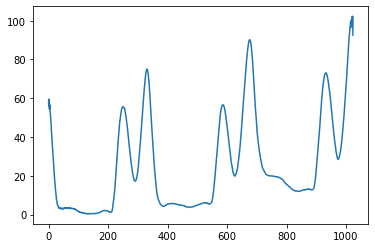

In [35]:
plt.plot(trajectory_z_r[:, 3])

In [76]:
from scipy.signal import butter, lfilter



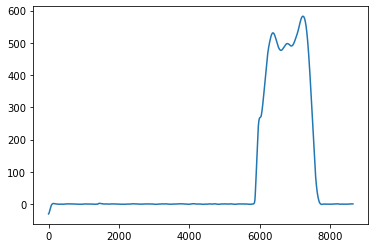

In [81]:
force_z_5_f = GrfFilter.apply(force_z_5)
# plt.plot(force_z_5)
plt.plot(force_z_5_f)

In [61]:
from scipy.stats import mode

In [80]:
mode(force_z_5_f)

ModeResult(mode=array([-30.79040291]), count=array([1]))

In [73]:
force_z_5_f[-10:]

array([30.88362737, 30.88465366, 30.88539435, 30.88910016, 30.89807098,
       30.90891313, 30.91956099, 30.93287182, 30.94802726, 30.96093286])

In [75]:
np.median(force_z_5_f)

30.79870269837816

In [85]:
x = np.array([0, 0, 1, 1, 0, 1, 1, 0, 0])
np.min(np.argwhere(x == 1))

2

In [84]:
y = (x == 1)
np.argwhere(y == True)

array([[2],
       [3],
       [5],
       [6]])